In [ ]:
# TASK 1 (ML eng. only)

# Imagine the digits in the test set of the MNIST dataset
# (http://yann.lecun.com/exdb/mnist/) got cut in half vertically and shuffled around. Although the
# two resulting halves of each image do not have any shared pixels, there are
# similarities in their structure. Implement a way to restore the original test
# set from the two halves, whilst maximising the overall matching accuracy.

my understanding of the problem: 
*   take the MNIST dataset (for example, train part with 60000 28*28 images),
*   divide every image into two parts vertically,
*   design some ML algorithm that is able to recover 60000 28*28 images having 120000 28*14 half-images  

What I've done:
*   wrote down a simple CNN that is making binary classification (i.e. true of fake image);
*   this CNN wgets as an input some 28*28 image generated via concatenation of some two half-images 28*14 and generates a label 0 <-> fake and 1 <-> real image;
*   for training I use 60000 MNIST 28*28 images as a real images and 60000 28*28 images generate from concatenation of shuffled 120000 28*14 half-images

{Such an approach is used for GAN's (I've picked up the discriminator part from a simple GAN).}


The general idea is to use a simple binary-classificator-CNN to train a model that understands if the 28*28 image is a mnist image or it is fake.

In [1]:
import numpy as np
from numpy import expand_dims
from numpy import ones, zeros
from numpy.random import rand, randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, BatchNormalization, LeakyReLU


def load_real_samples():
    # load mnist dataset
    (trainX, _), (_, _) = load_data()
    # expand to 3d, e.g. add channels dimension
    X = expand_dims(trainX, axis=-1)
    # convert from unsigned ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [0,1]
    X = X / 255.0
    return X

# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y

# generate n fake samples with class labels
def generate_fake_samples(dataset, n_samples):
    # randomly choose n_samples indexes
    ix = np.random.choice(dataset.shape[0], n_samples)

    X_1 = dataset[ix][:, :, :14]
    X_2 = dataset[ix][:, :, 14:]

    X = np.concatenate([X_1, X_2])
    np.random.shuffle(X)

    X = np.concatenate([X[:n_samples], X[n_samples:]], axis = 2)
    # generate 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

# a simple CNN
def define_model(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(64, (3,3),  padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3),  padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='relu'))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(learning_rate=0.0001, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# train it
def train_model(model, dataset, n_iter=5000, n_batch=256):
    half_batch = int(n_batch / 2)

    for i in range(n_iter):
        # get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # update model on real samples
        _, real_acc = model.train_on_batch(X_real, y_real)
        # generate 'fake' examples
        X_fake, y_fake = generate_fake_samples(dataset, half_batch)
        # update model on fake samples
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        # summarize the performance
        if i % 100 == 0:
            print('iteration %d: real images acc=%.0f%% fake images acc=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

# define the model
model = define_model()

# load image data
dataset = load_real_samples()

# fit the model
train_model(model, dataset)

11501568/11490434 [==============================] - 1s 0us/step
iteration 1: real images acc=67% fake images acc=9%
iteration 101: real images acc=98% fake images acc=72%
iteration 201: real images acc=100% fake images acc=66%
iteration 301: real images acc=99% fake images acc=69%
iteration 401: real images acc=97% fake images acc=80%
iteration 501: real images acc=97% fake images acc=78%
iteration 601: real images acc=99% fake images acc=87%
iteration 701: real images acc=99% fake images acc=86%
iteration 801: real images acc=98% fake images acc=89%
iteration 901: real images acc=97% fake images acc=85%
iteration 1001: real images acc=97% fake images acc=88%
iteration 1101: real images acc=98% fake images acc=88%
iteration 1201: real images acc=98% fake images acc=86%
iteration 1301: real images acc=99% fake images acc=93%
iteration 1401: real images acc=98% fake images acc=84%
iteration 1501: real images acc=100% fake images acc=91%
iteration 1601: real images acc=99% fake images ac

In [5]:
model.save_weights("weights_ntropy.h5")

In [2]:
model.load_weights("weights_ntropy.h5")

As we see it is able to learn something. Let's take some examples and see how it performs.

array([[0.9988132]], dtype=float32)

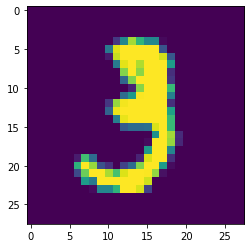

In [3]:
import matplotlib.pyplot as plt

some_image = dataset[10]
plt.imshow(some_image)
some_image = some_image.reshape(1,28,28,1)

model.predict(some_image)

99.8% of confidence that it's a MNIST image (it is).

Let's go further and generate a fake image:

array([[9.473282e-20]], dtype=float32)

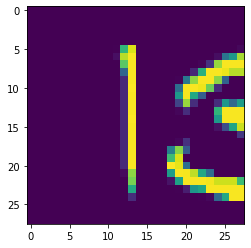

In [4]:
x_1 = dataset[14][:, :14]
x_2 = dataset[11232][:, :14]

some_image_2 = np.concatenate([x_1, x_2], axis=1).reshape(1,28,28,1)
plt.imshow(some_image_2[0])

model.predict(some_image_2)

This is fake, obviously (left half of one image with left half will almost always give a fake). But what about combining left half of one image with right half of another?

array([[0.00053647]], dtype=float32)

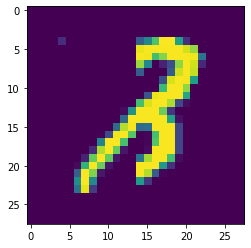

In [5]:
x_1 = dataset[1123][:, :14]
x_2 = dataset[157][:, 14:]

some_image_2 = np.concatenate([x_1, x_2], axis=1).reshape(1,28,28,1)
plt.imshow(some_image_2[0])

model.predict(some_image_2)

With very high probability this is fake also. And it is! Cool!

Further I do the following: 
* dividing the MNIST dataset into 2 parts vertically (generating 120000 28*14 images)
* concatenating, then shuffling
* arbitrarily picking one image (say image x) and successively concatinate it with all the 119999 images then predicting if the resulting image is fake or not. 

Of course this is not the best way to do, but as of limitation in time - let's do this MVP:

In [6]:
# dividing original dataset into 2 parts
X_1 = dataset[:, :, :14]
X_2 = dataset[:, :, 14:]

# print(X_1.shape, X_2.shape)

# concatenating and shuffling
X = np.concatenate([X_1, X_2])
np.random.shuffle(X)

In [7]:
# pick some image
our_image = X[128]

curr_proba = 0
best_proba = 0

i = 0
idx = -1

# here I take only first 1000 half-images just for an example, 
# it is a very-very unoptimized and takes huuuge time
for j in range(1000):
    i+=1
    curr_proba = model.predict(np.concatenate([our_image, X[j]], axis=1).reshape(1,28,28,1))
    if curr_proba > best_proba:
        best_proba = curr_proba
        idx = j
    if i % 100 == 0:
        print(i, best_proba, idx)

100 [[0.9127048]] 0
200 [[0.977462]] 184
300 [[0.9925848]] 208
400 [[0.9925848]] 208
500 [[0.9925848]] 208
600 [[0.9925848]] 208
700 [[0.9925848]] 208
800 [[0.9925848]] 208
900 [[0.99549913]] 810
1000 [[0.99549913]] 810


Well, it says that our_image + X[810] is not a fake (and at least in the first 1000 half-plots this is the best match). Let's plot this:

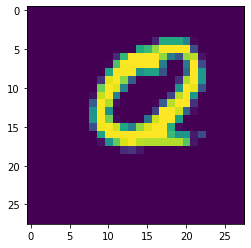

In [11]:
plt.imshow(np.concatenate([our_image, X[810]], axis = 1))

Nice! This might be zero. Take another case (just playing with it):

In [12]:
# pick another image
our_image_2 = X[12823]

curr_proba = 0
best_proba = 0

i = 0
idx = -1

for j in range(1000):
    i+=1
    curr_proba = model.predict(np.concatenate([our_image_2, X[j]], axis=1).reshape(1,28,28,1))
    if curr_proba > best_proba:
        best_proba = curr_proba
        idx = j
    if i % 100 == 0:
        print(i, best_proba, idx)

100 [[6.247276e-08]] 2
200 [[6.247276e-08]] 2
300 [[6.247276e-08]] 2
400 [[6.247276e-08]] 2
500 [[1.3099978e-07]] 480
600 [[1.3099978e-07]] 480
700 [[1.3099978e-07]] 480
800 [[1.3099978e-07]] 480
900 [[1.3099978e-07]] 480
1000 [[1.3099978e-07]] 480


Hmm, our image + everything in the first 1000 images are fake (e-07 possibility that this is real). Let's plot the best match:

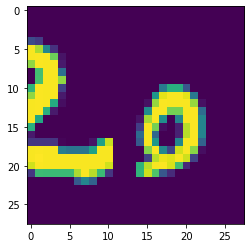

In [13]:
plt.imshow(np.concatenate([our_image_2, X[480]], axis = 1))

Ok, got it, this is fake (and everything where the left part will be a right part of the original will be apriori fake).

Well, seems that this works? ;)

  

Now, let's take say 100 images from MNIST dataset, write down a simple O(n^2) matching algorithm and see the accuracy of matching (of course the algorithm is not optimized at all).

PS outline of the algorithm at the end of this file.

In [42]:
rand_start = np.random.randint(1,100)
num_images = 100

X_1 = dataset[(rand_start - 1) * num_images : rand_start * num_images, :, :14]
X_2 = dataset[(rand_start - 1) * num_images : rand_start * num_images, :, 14:]
# print(X_1.shape, X_2.shape)

X_init = np.concatenate([X_1, X_2])
X_idx = np.arange(2 * num_images)
print('initial indexes:', X_idx)
print('\n')

np.random.shuffle(X_idx)
print('shuffled indexes:', X_idx)

initial indexes: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]


shuffled indexes: [ 53 183 158  32  41  13 152 127   2   8 170 150 153  67  50 107 151 184
 166  70  81 180  16  63 164  51  21 121  92  48 125 197  56 120  26  42
  14

In [44]:
matching_matrix = []

for i in range(num_images * 5):
    curr_image = X_init[X_idx[0]]

    curr_proba, best_proba = 0, 0
    idx = -1

    for j in range(len(X_idx)):
        curr_proba = model.predict(np.concatenate([curr_image, X_init[X_idx[j]]], axis=1).reshape(1,28,28,1))[0][0]
        if curr_proba > best_proba:
            best_proba = curr_proba
            idx = j
        
    if best_proba > 0.5:
        matching_matrix.append([X_idx[0], X_idx[idx]])
        X_idx = np.delete(X_idx, [0, idx])
        np.random.shuffle(X_idx)
#         print(X_idx)
#         print(X_idx.shape)
    else:
        np.random.shuffle(X_idx)
        
    if len(X_idx) == 2:
        matching_matrix.append([X_idx[0], X_idx[1]])
        break

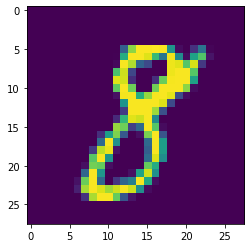

In [44]:
# check that we truly have num_images final images
assert np.shape(matching_matrix)[0] == num_images

# plot some recovered image
rand_int = np.random.randint(1,num_images)
plt.imshow(np.concatenate([X_init[matching_matrix[num_images-rand_int][0]], X_init[matching_matrix[num_images-rand_int][1]]], axis = 1))

In [46]:
# simplest accuracy counter

acc_counter = 0

for i in range(num_images):
    if (matching_matrix[i][1] - num_images) == (matching_matrix[i][0]):
        acc_counter += 1
    else:
        pass

print(acc_counter/num_images)

0.88


Nice!!! 88% of accurate matching on 100-image dataset. 
Seems that even this simplest-simplest algorithm works. And Of course, there is a lot of room to improve it (like use greedy algorithms or some type of random search or something else).

OK, but what it is doing?
1. first I've trained a binary classification NN model on a dataset consisting of real MNIST images and fakes (divided and shuffled real MNIST) for around 5000 iterations.

2. then I took the trained weights to see how it is working: as an example took one half of original MNIST image, take say 1000 other halfs and calculated probabilities of being real/fake if these images are concatenated (1 stands for real, 0 for fake).

3. finally, I wrote a simples O(n^2) matching algorithm that works on say 200 half-images dataset generated from 100 real MNIST ones. The algorithm
*   takes one half-image and gets the highest match from remaining 199;
*   deletes these two half-images and takes one from the remaining 198 images and gets the highest match;
*   and so on generating a matching_matrix which has 100 rows each containing two numbers (xx, yy) standing for left and right halfs that if concatenated are seems to be real.

Finally, I just took this matching_matrix and checked where yy - num_images == xx (which means that we have EXACT match).

Overall, this is a 